# The Task
- For this assignment, you will be building a machine learning model to predict car price using all of the provided features.
- Specifically, you will:
    - Preprocess the data as dataframes with feature names using the updated column transformer.
    - Fit and evaluate a Tree Based Model of your choice.
        - Evaluate training and test data using R-squared and RMSE.
    - Extract and Plot the Feature Importances calculated by your model.
        - Answer the Qs:
            - What were your 5 most important features?
            - What does it mean that they were "important"?
    - Apply sklearn's permutation importance and visualize the permutation importances.
        - Answer the Qs:
            - What were your 5 most important features?
            - Are they the same features that your model has as the top 5 important?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector 
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.inspection import permutation_importance

# models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [2]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSnWFRczgXa0AyKkbioX5Roq60X7GTAFilKtpFuAmyGi9uPMwdb51Jo-cpupDyjhT0EVqcNRJPINZ5b/pub?output=csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   fueltype          205 non-null    object 
 2   aspiration        205 non-null    object 
 3   doornumber        205 non-null    object 
 4   carbody           205 non-null    object 
 5   drivewheel        205 non-null    object 
 6   enginelocation    205 non-null    object 
 7   wheelbase         205 non-null    float64
 8   carlength         205 non-null    float64
 9   carwidth          205 non-null    float64
 10  carheight         205 non-null    float64
 11  curbweight        205 non-null    int64  
 12  enginetype        205 non-null    object 
 13  cylindernumber    205 non-null    int64  
 14  enginesize        205 non-null    int64  
 15  fuelsystem        205 non-null    object 
 16  boreratio         205 non-null    float64
 1

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [3]:
df.isna().sum().sum()

0

In [4]:
duplicated = df.duplicated().sum()
df = df.drop_duplicates()
duplicated_drop = df.duplicated().sum()
print(f'We had a total numbers of {duplicated} duplicates in our data \
And have a total of {duplicated_drop} duplicates after dropping.')

We had a total numbers of 1 duplicates in our data And have a total of 0 duplicates after dropping.


# Preprocessing

In [5]:
target = 'price'

y = df[target]
X = df.drop(columns = target)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [6]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (153, 23)
X_test shape: (51, 23)
y_train shape: (153,)
y_test shape: (51,)


In [7]:
data_types = df.dtypes
obj_data = data_types[(data_types == 'object')]

for column in obj_data.index:
  print(column)
  print(f'Unique Values: {df[column].unique()}\n')

fueltype
Unique Values: ['gas' 'diesel']

aspiration
Unique Values: ['std' 'turbo']

doornumber
Unique Values: ['two' 'four']

carbody
Unique Values: ['convertible' 'hatchback' 'sedan' 'wagon' 'hardtop']

drivewheel
Unique Values: ['rwd' 'fwd' '4wd']

enginelocation
Unique Values: ['front' 'rear']

enginetype
Unique Values: ['dohc' 'ohcv' 'ohc' 'l' 'rotor' 'ohcf' 'dohcv']

fuelsystem
Unique Values: ['mpfi' '2bbl' 'mfi' '1bbl' 'spfi' '4bbl' 'idi' 'spdi']



We don't have any ordinal features in our data set.

In [8]:
nominal_features = make_column_selector(dtype_include  ='object')
ohe = OneHotEncoder(handle_unknown = 'ignore')
nom_tuple = (ohe, nominal_features)

In [9]:
numerical_features = make_column_selector(dtype_include = 'number')
num_scaler = StandardScaler()
num_tuple = (num_scaler, numerical_features)

In [10]:
preprocessor = make_column_transformer (nom_tuple, 
                                        num_tuple,
                                        remainder = 'drop', 
                                        verbose_feature_names_out = False)

In [11]:
# Checking if preprocessor works
preprocessor.fit(X_train) # will fail if it doesnt work

# save the output of get_feature_names_out()
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['fueltype_diesel', 'fueltype_gas', 'aspiration_std',
       'aspiration_turbo', 'doornumber_four', 'doornumber_two',
       'carbody_convertible', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_4wd',
       'drivewheel_fwd', 'drivewheel_rwd', 'enginelocation_front',
       'enginelocation_rear', 'enginetype_dohc', 'enginetype_l',
       'enginetype_ohc', 'enginetype_ohcf', 'enginetype_ohcv',
       'enginetype_rotor', 'fuelsystem_1bbl', 'fuelsystem_2bbl',
       'fuelsystem_4bbl', 'fuelsystem_idi', 'fuelsystem_mpfi',
       'fuelsystem_spdi', 'fuelsystem_spfi', 'symboling', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight',
       'cylindernumber', 'enginesize', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg',
       'highwaympg'], dtype=object)

In [12]:
# preprocess DF to training set
X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)
X_train_df.sample(3)

,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,...,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
165,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,-0.582771,-0.379851,-0.700619,-0.301349,-0.585409,-0.172700,0.216190,3.028543,0.167890,-0.212680
28,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.065156,-0.379851,-0.140124,0.075337,0.650904,-0.407178,-0.427124,-0.263585,-0.161433,-0.059189
8,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.991161,0.514259,0.070062,-0.715704,0.455696,-0.459285,0.966723,0.765205,-1.314066,-1.594093


In [13]:
# preprocess DF to testing set
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                         columns = feature_names, index = X_test.index)
X_test_df.sample(3)

,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,...,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
19,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,-1.332354,-0.379851,-0.887451,-1.092391,-0.487806,-0.120594,-0.909609,0.559447,2.143833,1.936186
168,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,-0.063239,-0.379851,0.420371,1.130059,0.781042,-0.198753,0.323409,-0.675101,-0.161433,-0.059189
156,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,-0.935516,-0.379851,-0.700619,-0.489692,-0.748082,-0.276913,-0.909609,-0.675101,0.826538,1.015244


# Feature Importance

In [14]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [15]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

In [16]:
def plot_importance_color_ax(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None, ax=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize, ax=ax)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [17]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

## Decision Tree Model

In [18]:
dec_tree = DecisionTreeRegressor(random_state = 32)
dec_tree.fit(X_train_df, y_train)
evaluate_regression(dec_tree, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 1.00	RMSE= 298.01
Test Data:	R^2= 0.90	RMSE= 2713.85


### Feature Importance

In [19]:
feature_importance = pd.Series(dec_tree.feature_importances_, 
                               index = feature_names, 
                               name = 'Decision Tree Feature Importance')
print(feature_importance)

fueltype_diesel         0.000002
fueltype_gas            0.000000
aspiration_std          0.000000
aspiration_turbo        0.001023
doornumber_four         0.000127
doornumber_two          0.000000
carbody_convertible     0.000276
carbody_hardtop         0.000000
carbody_hatchback       0.001074
carbody_sedan           0.000010
carbody_wagon           0.000032
drivewheel_4wd          0.000027
drivewheel_fwd          0.000050
drivewheel_rwd          0.000127
enginelocation_front    0.000000
enginelocation_rear     0.000000
enginetype_dohc         0.000014
enginetype_l            0.000000
enginetype_ohc          0.000042
enginetype_ohcf         0.000000
enginetype_ohcv         0.000000
enginetype_rotor        0.000000
fuelsystem_1bbl         0.000007
fuelsystem_2bbl         0.000082
fuelsystem_4bbl         0.000000
fuelsystem_idi          0.000000
fuelsystem_mpfi         0.000075
fuelsystem_spdi         0.000000
fuelsystem_spfi         0.000000
symboling               0.000388
wheelbase 

<AxesSubplot: title={'center': 'Top 10 Most Important Features'}, xlabel='Importance', ylabel='Feature Names'>

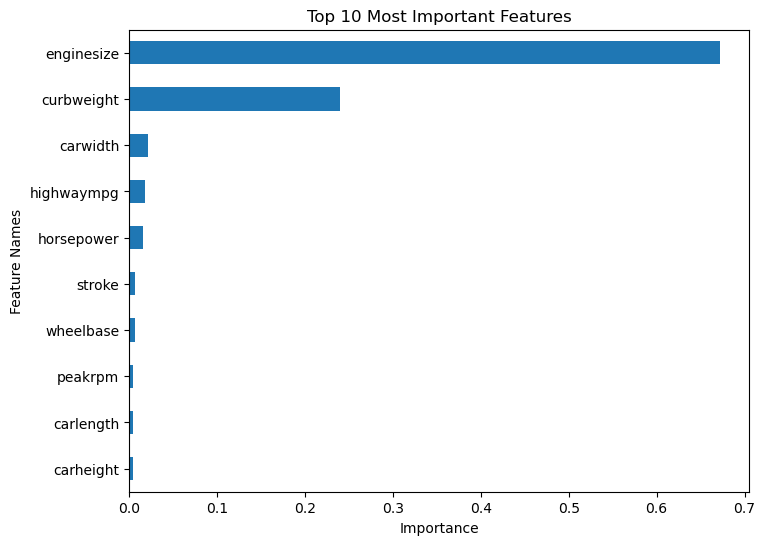

In [20]:
plot_importance(feature_importance, top_n = 10)

Questions: 

1. What were your 5 most important features?
    1. Enginesize
    2. curbweight
    3. carwidth
    4. highwaympg
    5. horsepower
2. What does it mean that they were "important"?
    - Feature Importance refers to techniques that calculate a score for all the input features for a given model — the scores simply represent the “importance” of each feature. A higher score means that the specific feature will have a larger effect on the model that is being used to predict a certain variable.
    
### Permutation Importance

In [21]:
# Permutation importance takes a fit model and the test data.
r = permutation_importance(dec_tree, X_test_df, y_test,n_repeats = 5)
print(r.keys())

dict_keys(['importances_mean', 'importances_std', 'importances'])


In [22]:
## can make the mean importances into a series
permutation_importances = pd.Series(r['importances_mean'],
                                    index = X_test_df.columns,
                                    name = 'Permutation Importance')
permutation_importances = permutation_importances.sort_values(ascending = False)
permutation_importances

enginesize              1.095764
curbweight              0.251733
carlength               0.021996
carwidth                0.021523
highwaympg              0.020473
horsepower              0.012467
stroke                  0.011715
carbody_hatchback       0.010178
citympg                 0.004384
aspiration_turbo        0.001408
wheelbase               0.001275
boreratio               0.001102
fuelsystem_2bbl         0.000729
peakrpm                 0.000627
fuelsystem_1bbl         0.000213
fuelsystem_mpfi         0.000063
enginelocation_rear     0.000000
aspiration_std          0.000000
doornumber_two          0.000000
carbody_convertible     0.000000
carbody_hardtop         0.000000
cylindernumber          0.000000
drivewheel_4wd          0.000000
drivewheel_rwd          0.000000
fuelsystem_spfi         0.000000
fuelsystem_spdi         0.000000
fueltype_diesel         0.000000
fuelsystem_idi          0.000000
fuelsystem_4bbl         0.000000
enginetype_l            0.000000
enginetype

<AxesSubplot: title={'center': 'Top 10 Most Important Features'}, xlabel='Importance', ylabel='Feature Names'>

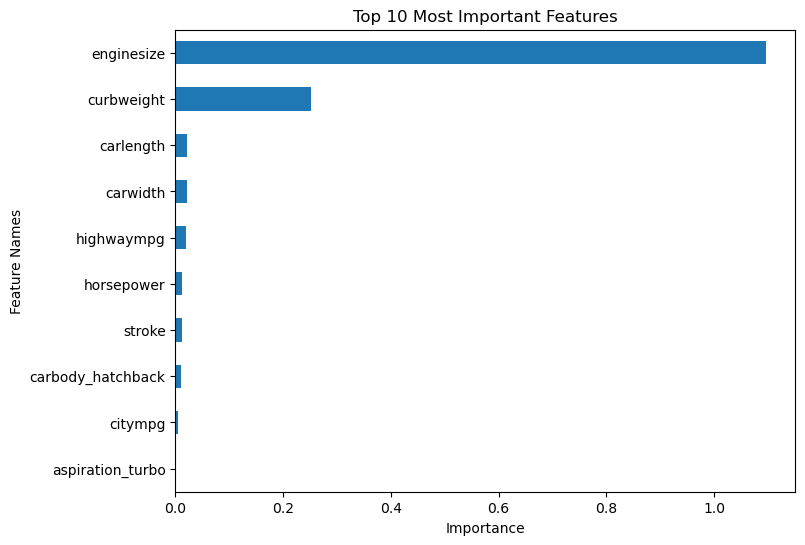

In [23]:
plot_importance(permutation_importances, top_n = 10)

Question: 
1. What were your 5 most important features?
    1. enginesize
    2. curbweight
    4. carwitht
    5. highwaympg
    6. stroke
2. Are they the same features that your model has as the top 5 important?
    - No, stroke did NOT apprear on the other feature.

## Random Forest Model

In [24]:
ran_for = RandomForestRegressor(random_state = 32)
ran_for.fit(X_train_df, y_train)
evaluate_regression(ran_for, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.99	RMSE= 865.87
Test Data:	R^2= 0.93	RMSE= 2279.60


### Features

In [25]:
# Feature Importance
rf_feature_importance = pd.Series(ran_for.feature_importances_, 
                                  index = feature_names)

In [26]:
# Permutation Importance#
rf_r = permutation_importance(ran_for, X_test_df, y_test,n_repeats = 5)
rf_permutation_importances = pd.Series(rf_r['importances_mean'],
                                       index = X_test_df.columns)

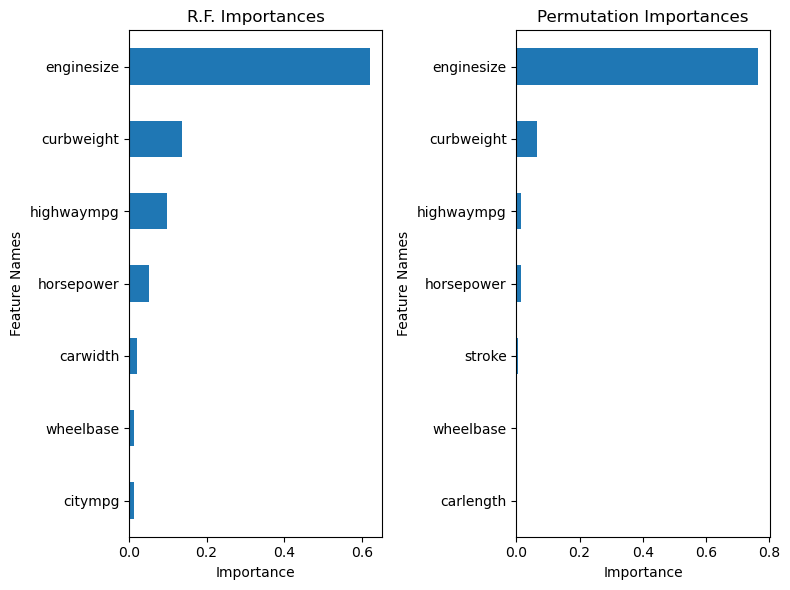

In [27]:
# [!] COLOR_DICT is removed for now, still could not figure that one out

fig, axes = plt.subplots(ncols=2, figsize=(20,8))
n = 7 # setting the # of features to use for both subplots
plot_importance_color_ax(rf_feature_importance, top_n = n, ax = axes[0])
plot_importance_color_ax(rf_permutation_importances, top_n = n, ax = axes[1])
axes[0].set(title='R.F. Importances')
axes[1].set(title='Permutation Importances')
fig.tight_layout()

## LGBMRegressor

In [28]:
lgbm = LGBMRegressor(random_state = 32)
lgbm.fit(X_train_df, y_train)
evaluate_regression(lgbm, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.96	RMSE= 1515.90
Test Data:	R^2= 0.88	RMSE= 2986.16


### Features

In [29]:
# Feature Importance
lgbm_feature_importance = pd.Series(lgbm.feature_importances_, 
                                    index = feature_names)

In [30]:
# Permutation Importance#
lgbm_r = permutation_importance(lgbm, X_test_df, y_test,n_repeats = 5)
lgbm_permutation_importances = pd.Series(lgbm_r['importances_mean'],
                                         index = X_test_df.columns)

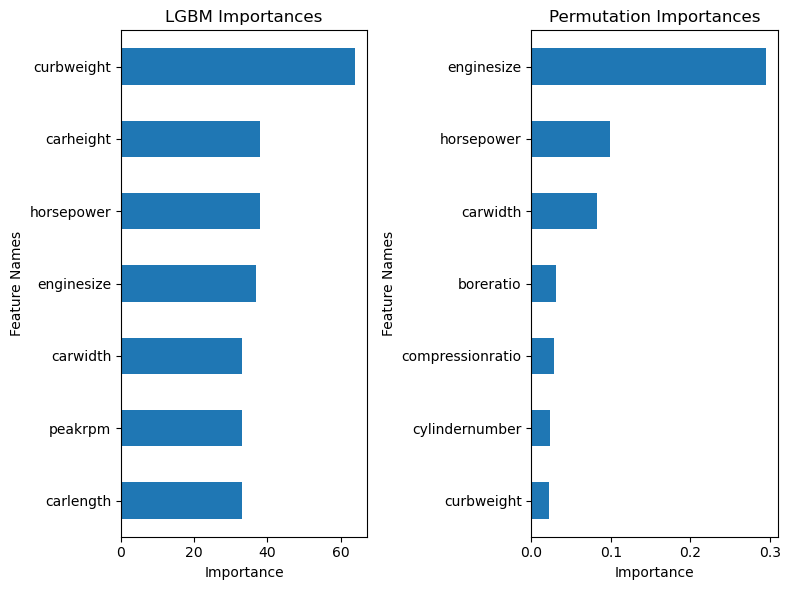

In [31]:
# [!] COLOR_DICT is removed for now, still could not figure that one out

fig, axes = plt.subplots(ncols=2, figsize=(20,8))
n = 7 # setting the # of features to use for both subplots
plot_importance_color_ax(lgbm_feature_importance, top_n = n, ax = axes[0])
plot_importance_color_ax(lgbm_permutation_importances, top_n = n, ax = axes[1])
axes[0].set(title='LGBM Importances')
axes[1].set(title='Permutation Importances')
fig.tight_layout()